In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

EDA

In [2]:
df = pd.read_csv('data_hw.csv')

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

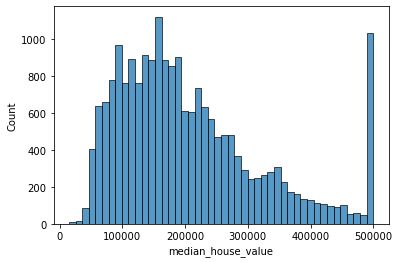

In [3]:
sns.histplot(data=df["median_house_value"]) 
# It doesn't have a long tail

Selecting only the features we will use for the rest of this project

In [4]:
base = [
    "latitude",
    "longitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "median_house_value",
]

In [5]:
df = df[base]
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


#### Question 1

Find a feature with missing values. 

In [6]:
df.isnull().sum() # Only total_bedrooms has missing values

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

How many missing values does it have?   207 missing values

#### Question 2

What's the median (50% percentile) for variable 'population'? 1166

In [7]:
df.population.describe() # 1166

count    20640.000000
mean      1425.476744
std       1132.462122
min          3.000000
25%        787.000000
50%       1166.000000
75%       1725.000000
max      35682.000000
Name: population, dtype: float64

##### Split the data

In [8]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)

In [9]:
n_val, n_test, n_train

(4128, 4128, 12384)

In [10]:
idx = np.arange(n)

In [12]:
np.random.seed(42)
np.random.shuffle(idx)

In [13]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train : n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = np.log1p(df_train['median_house_value'])
y_val = np.log1p(df_val['median_house_value'])
y_test = np.log1p(df_test['median_house_value'])

In [16]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

#### Question 3

Train with missing values having the mean

In [129]:
def prepare_X_mean(df):
    df = df.copy()
    mean_value = df['total_bedrooms'].mean()
    df_num = df.fillna(mean_value)
    return df_num.values


In [130]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [131]:
X_train_mean = prepare_X_mean(df_train)
w0, w = train_linear_regression(X_train_mean, y_train)
w0, w

(-11.751639988048064,
 array([-2.79802066e-01, -2.75735269e-01,  2.98739771e-03, -3.80526032e-05,
         3.93940132e-04, -1.67773628e-04,  3.68965675e-04,  1.79232946e-01]))

In [132]:
y_pred_mean = X_train_mean.dot(w)
y_pred_mean

array([24.31038144, 24.15876901, 23.69803888, ..., 24.08046672,
       24.08961702, 23.49631279])

In [133]:
def rmse(y_actual, y_pred):
    se = (y_actual - y_pred) ** 2
    mse = se.mean()
    return np.round(np.sqrt(mse), 2)

In [134]:
rmse(y_train, y_pred_mean)

11.76

Train with missing values having 0

In [135]:
def prepare_X_0(df):
    df = df.copy()
    df_num = df.fillna(0)
    return df_num.values

In [136]:
X_train_0 = prepare_X_0(df_train)
w0, w = train_linear_regression(X_train_0, y_train)
w0, w

(-11.656344592947848,
 array([-2.79575533e-01, -2.74957864e-01,  2.96901022e-03, -3.08573725e-05,
         2.72124602e-04, -1.72139115e-04,  4.73645441e-04,  1.77186117e-01]))

In [137]:
y_pred_0 = X_train_0.dot(w)
y_pred_0

array([24.21728819, 24.06802089, 23.61633486, ..., 23.99083422,
       23.99366434, 23.40701871])

In [138]:
rmse(y_train, y_pred_0) # with missing values set to 0 the RMSE becomes 11.75

11.66

Set the validation framework

With 0

In [139]:
X_val = prepare_X_0(df_val)
w0, w = train_linear_regression(X_val, y_val)

In [147]:
y_pred = w0 + X_val.dot(w)

In [148]:
rmse(y_val, y_pred) # RMSE with 0 for validation

0.34

With mean

In [154]:
X_val = prepare_X_mean(df_val)
w0, w = train_linear_regression(X_val, y_val)

In [155]:
y_pred = w0 + X_val.dot(w)

In [157]:
rmse(y_val, y_pred) # RMSE with mean for validation
# Both of the model's performances are equal

0.34

#### Question 4

In [158]:
def train_linear_regression_reg(X, y, r=0.01):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [161]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X_train = prepare_X_0(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X_0(df_val)
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred)

    print(score, r,)
# The best RMSE is for the regularization value 0

0.34 0
0.34 1e-06
0.34 0.0001
0.34 0.001
0.34 0.01
0.34 0.1
0.35 1
0.35 5
0.35 10


#### Question 5

In [176]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = np.array([])

for s in seeds:
    n = len(df)

    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)

    np.random.seed(s)
    np.random.shuffle(idx)

    df = df.copy()
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train : n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val :]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train["median_house_value"])
    y_val = np.log1p(df_val["median_house_value"])
    y_test = np.log1p(df_test["median_house_value"])

    del df_train["median_house_value"]
    del df_val["median_house_value"]
    del df_test["median_house_value"]

    # training
    X_train = prepare_X_0(df_train)
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_train.dot(w)
    print("rmse for training %s" % rmse(y_train, y_pred))

    # validation
    X_val = prepare_X_0(df_val)
    w0, w = train_linear_regression(X_val, y_val)
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred)
    scores[s] = score

rmse for training 0.34
rmse for training 0.34
rmse for training 0.34
rmse for training 0.34
rmse for training 0.34
rmse for training 0.34
rmse for training 0.34
rmse for training 0.34
rmse for training 0.34
rmse for training 0.34


In [186]:
std = np.std(list(scores.values()))
np.round(std, 3)
# The value of the standard deviation of the scores is roughly 0.005

0.004

#### Question 6

In [187]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)

idx = np.arange(n)

np.random.seed(9)
np.random.shuffle(idx)

df = df.copy()
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train : n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val :]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train["median_house_value"])
y_val = np.log1p(df_val["median_house_value"])
y_test = np.log1p(df_test["median_house_value"])

del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]

# combining traiing and validation datasets
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

X_full_train = prepare_X_0(df_full_train)

y_full_train = np.concatenate([y_train, y_val])

w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

# validation
X = prepare_X_0(df_test)
y_pred = w0 + X.dot(w)

rmse(y_test, y_pred)

0.35